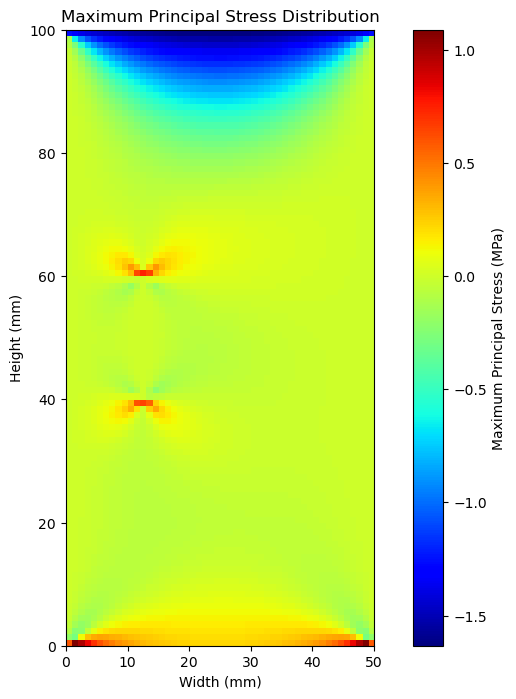

In [2]:
import numpy as np
from scipy.sparse import lil_matrix, csr_matrix
from scipy.sparse.linalg import spsolve
from numba import jit
import matplotlib.pyplot as plt
#导入

@jit(nopython=True)
def compute_element_matrix(node_coords, E_e, nu, thickness):
    """计算单元刚度矩阵"""
    D = E_e/(1 - nu**2) * np.array([[1, nu, 0],
                                   [nu, 1, 0],
                                   [0, 0, (1-nu)/2]])
    
    # 高斯积分点
    gauss_points = np.array([(-0.57735026919, -0.57735026919),
                            (0.57735026919, -0.57735026919),
                            (0.57735026919, 0.57735026919),
                            (-0.57735026919, 0.57735026919)])
    weights = np.array([1.0, 1.0, 1.0, 1.0])
    
    Ke = np.zeros((8, 8))
    for i in range(4):
        xi, eta = gauss_points[i]
        w = weights[i]
        
        dN_dxi = 0.25 * np.array([
            [eta-1, 1-eta, 1+eta, -eta-1],
            [xi-1, -xi-1, xi+1, 1-xi]
        ])
        
        J = dN_dxi @ node_coords
        detJ = J[0,0]*J[1,1] - J[0,1]*J[1,0]
        
        # 计算J的逆矩阵
        invJ = np.array([[J[1,1], -J[0,1]], [-J[1,0], J[0,0]]]) / detJ
        dN_dx = invJ @ dN_dxi
        
        B = np.zeros((3, 8))
        for j in range(4):
            B[0, 2*j] = dN_dx[0, j]
            B[1, 2*j+1] = dN_dx[1, j]
            B[2, 2*j] = dN_dx[1, j]
            B[2, 2*j+1] = dN_dx[0, j]
        
        Ke += (B.T @ D @ B) * detJ * w * thickness
    
    return Ke

def main():
    # 参数设置
    nx, ny = 50, 100
    width, height = 50.0, 100.0
    E = 210e3
    nu = 0.3
    thickness = 1.0
    applied_stress = -6.0
    crack_x = (12, 13)
    crack_y = (40, 60)

    # 生成网格
    x = np.linspace(0, width, nx + 1)
    y = np.linspace(0, height, ny + 1)
    X, Y = np.meshgrid(x, y)
    nodes = np.column_stack((X.flatten(), Y.flatten()))

    # 生成单元连接性（向量化操作）
    i = np.arange(nx*ny)
    row = i // nx
    col = i % nx
    n0 = row*(nx+1) + col
    elements = np.column_stack((n0, n0+1, n0+nx+2, n0+nx+1))

    # 标记裂纹区域（向量化操作）
    element_centers = np.mean(nodes[elements], axis=1)
    crack_mask = ((crack_x[0] <= element_centers[:,0]) & 
                 (element_centers[:,0] <= crack_x[1]) & 
                 (crack_y[0] <= element_centers[:,1]) & 
                 (element_centers[:,1] <= crack_y[1]))
    E_values = np.where(crack_mask, 1e-6, E)

    # 组装刚度矩阵
    dof = 2 * len(nodes)
    K = lil_matrix((dof, dof))

    # 并行计算单元刚度矩阵
    for elem_idx, elem in enumerate(elements):
        node_coords = nodes[elem]
        Ke = compute_element_matrix(node_coords, E_values[elem_idx], nu, thickness)
        
        # 组装到全局矩阵
        dofs = np.array([[2*n, 2*n+1] for n in elem]).flatten()
        for i in range(8):
            for j in range(8):
                K[dofs[i], dofs[j]] += Ke[i,j]

    # K = csr_matrix(K)

    # # 边界条件（向量化操作）
    # bottom_nodes = np.where(nodes[:,1] == 0.0)[0]
    # fixed_dofs = np.concatenate([2*bottom_nodes, 2*bottom_nodes+1])

    # # 载荷向量
    # F = np.zeros(dof)
    # top_nodes = np.where(nodes[:,1] == height)[0]
    # force_per_node = applied_stress * width * thickness / len(top_nodes)
    # F[2*top_nodes + 1] = force_per_node

    # # 处理边界条件
    # for fd in fixed_dofs:
    #     F[fd] = 0.0
    #     K[fd, :] = 0
    #     K[:, fd] = 0
    #     K[fd, fd] = 1.0

    # # 求解
    # U = spsolve(K, F)
    # 边界条件（向量化操作）
    bottom_nodes = np.where(nodes[:,1] == 0.0)[0]
    fixed_dofs = np.concatenate([2*bottom_nodes, 2*bottom_nodes+1])

    # 载荷向量
    F = np.zeros(dof)
    top_nodes = np.where(nodes[:,1] == height)[0]
    force_per_node = applied_stress * width * thickness / len(top_nodes)
    F[2*top_nodes + 1] = force_per_node

    # 处理边界条件
    for fd in fixed_dofs:
        F[fd] = 0.0
        K[fd, :] = 0
        K[:, fd] = 0
        K[fd, fd] = 1.0

    # 转换为CSR格式并求解
    K = csr_matrix(K)
    U = spsolve(K, F)

    # 计算应力（向量化操作）
    stress_matrix = np.zeros((ny, nx))
    for idx, elem in enumerate(elements):
        node_coords = nodes[elem]
        u = np.concatenate([U[2*elem[i]:2*elem[i]+2] for i in range(4)])
        
        # 计算中心点应力
        xi, eta = 0.0, 0.0
        dN_dxi = 0.25 * np.array([
            [eta-1, 1-eta, 1+eta, -eta-1],
            [xi-1, -xi-1, xi+1, 1-xi]
        ])
        J = dN_dxi @ node_coords
        dN_dx = np.linalg.inv(J) @ dN_dxi
        
        B = np.zeros((3, 8))
        for i in range(4):
            B[0, 2*i] = dN_dx[0, i]
            B[1, 2*i+1] = dN_dx[1, i]
            B[2, 2*i] = dN_dx[1, i]
            B[2, 2*i+1] = dN_dx[0, i]
        
        strain = B @ u
        E_e = E_values[idx]
        D = E_e/(1 - nu**2) * np.array([[1, nu, 0],
                                       [nu, 1, 0],
                                       [0, 0, (1-nu)/2]])
        stress = D @ strain
        
        s_x, s_y, t_xy = stress
        avg = (s_x + s_y)/2
        radius = np.sqrt(((s_x - s_y)/2)**2 + t_xy**2)
        sigma1 = avg + radius
        stress_matrix[idx//nx, idx%nx] = sigma1

    # 绘图
    plt.figure(figsize=(10, 8))
    plt.imshow(stress_matrix, cmap='jet', extent=[0, width, 0, height])
    plt.colorbar(label='Maximum Principal Stress (MPa)')
    plt.xlabel('Width (mm)')
    plt.ylabel('Height (mm)')
    plt.title('Maximum Principal Stress Distribution')
    plt.show()

if __name__ == "__main__":
    main()

In [5]:
! pip install numpy==1.21

     ---------------------------------------- 14.0/14.0 MB 4.0 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.22.0
    Uninstalling numpy-1.22.0:
      Successfully uninstalled numpy-1.22.0


ERROR: Could not install packages due to an OSError: [WinError 5] 拒绝访问。: 'D:\\anaconda\\Lib\\site-packages\\~.mpy\\.libs\\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll'
Consider using the `--user` option or check the permissions.



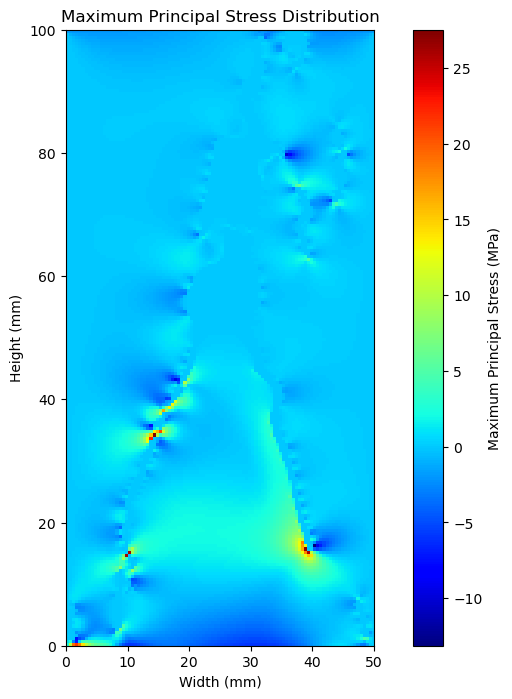

In [ ]:
import numpy as np
from scipy.sparse import lil_matrix, csr_matrix
from scipy.sparse.linalg import spsolve
from numba import jit
import matplotlib.pyplot as plt
from PIL import Image

@jit(nopython=True)
def compute_element_matrix(node_coords, E_e, nu, thickness):
    """计算单元刚度矩阵"""
    D = E_e/(1 - nu**2) * np.array([[1, nu, 0],
                                     [nu, 1, 0],
                                     [0, 0, (1-nu)/2]])

    # 高斯积分点
    gauss_points = np.array([(-0.57735026919, -0.57735026919),
                             (0.57735026919, -0.57735026919),
                             (0.57735026919, 0.57735026919),
                             (-0.57735026919, 0.57735026919)])
    weights = np.array([1.0, 1.0, 1.0, 1.0])

    Ke = np.zeros((8, 8))
    for i in range(4):
        xi, eta = gauss_points[i]
        w = weights[i]

        dN_dxi = 0.25 * np.array([
            [eta-1, 1-eta, 1+eta, -eta-1],
            [xi-1, -xi-1, xi+1, 1-xi]
        ])

        J = dN_dxi @ node_coords
        detJ = J[0,0]*J[1,1] - J[0,1]*J[1,0]

        # 计算J的逆矩阵
        invJ = np.array([[J[1,1], -J[0,1]], [-J[1,0], J[0,0]]]) / detJ
        dN_dx = invJ @ dN_dxi

        B = np.zeros((3, 8))
        for j in range(4):
            B[0, 2*j] = dN_dx[0, j]
            B[1, 2*j+1] = dN_dx[1, j]
            B[2, 2*j] = dN_dx[1, j]
            B[2, 2*j+1] = dN_dx[0, j]

        Ke += (B.T @ D @ B) * detJ * w * thickness

    return Ke

def main():
    # 参数设置
    nx, ny = 100, 200
    width, height = 50.0, 100.0
    E = 210e3
    nu = 0.3
    thickness = 1.0
    applied_stress = -6.0

    # 读取mask图像
    mask_image = Image.open("label142.png").convert("L")  # 转为灰度图
    mask_array = np.array(mask_image)
    # 调整mask数组大小以匹配有限元网格
    mask_array = np.array(Image.fromarray(mask_array).resize((nx, ny)))

    # 生成网格
    x = np.linspace(0, width, nx + 1)
    y = np.linspace(0, height, ny + 1)
    X, Y = np.meshgrid(x, y)
    nodes = np.column_stack((X.flatten(), Y.flatten()))

    # 生成单元连接性（向量化操作）
    i = np.arange(nx*ny)
    row = i // nx
    col = i % nx
    n0 = row*(nx+1) + col
    elements = np.column_stack((n0, n0+1, n0+nx+2, n0+nx+1))

    # 使用mask标记裂纹区域（向量化操作）
    E_values = np.where(mask_array.flatten() > 128, 1e-6, E)  # 白色区域弹性模量设为极小值


    # 组装刚度矩阵
    dof = 2 * len(nodes)
    K = lil_matrix((dof, dof))

    # 并行计算单元刚度矩阵
    for elem_idx, elem in enumerate(elements):
        node_coords = nodes[elem]
        Ke = compute_element_matrix(node_coords, E_values[elem_idx], nu, thickness)

        # 组装到全局矩阵
        dofs = np.array([[2*n, 2*n+1] for n in elem]).flatten()
        for i in range(8):
            for j in range(8):
                K[dofs[i], dofs[j]] += Ke[i,j]


    # 边界条件（向量化操作）
    bottom_nodes = np.where(nodes[:,1] == 0.0)[0]
    fixed_dofs = np.concatenate([2*bottom_nodes, 2*bottom_nodes+1])

    # 载荷向量
    F = np.zeros(dof)
    top_nodes = np.where(nodes[:,1] == height)[0]
    force_per_node = applied_stress * width * thickness / len(top_nodes)
    F[2*top_nodes + 1] = force_per_node

    # 处理边界条件
    for fd in fixed_dofs:
        F[fd] = 0.0
        K[fd, :] = 0
        K[:, fd] = 0
        K[fd, fd] = 1.0

    # 转换为CSR格式并求解
    K = csr_matrix(K)
    U = spsolve(K, F)

    # 计算应力（向量化操作）
    stress_matrix = np.zeros((ny, nx))
    for idx, elem in enumerate(elements):
        node_coords = nodes[elem]
        u = np.concatenate([U[2*elem[i]:2*elem[i]+2] for i in range(4)])

        # 计算中心点应力
        xi, eta = 0.0, 0.0
        dN_dxi = 0.25 * np.array([
            [eta-1, 1-eta, 1+eta, -eta-1],
            [xi-1, -xi-1, xi+1, 1-xi]
        ])
        J = dN_dxi @ node_coords
        dN_dx = np.linalg.inv(J) @ dN_dxi

        B = np.zeros((3, 8))
        for i in range(4):
            B[0, 2*i] = dN_dx[0, i]
            B[1, 2*i+1] = dN_dx[1, i]
            B[2, 2*i] = dN_dx[1, i]
            B[2, 2*i+1] = dN_dx[0, i]

        strain = B @ u
        E_e = E_values[idx]
        D = E_e/(1 - nu**2) * np.array([[1, nu, 0],
                                         [nu, 1, 0],
                                         [0, 0, (1-nu)/2]])
        stress = D @ strain

        s_x, s_y, t_xy = stress
        avg = (s_x + s_y)/2
        radius = np.sqrt(((s_x - s_y)/2)**2 + t_xy**2)
        sigma1 = avg + radius
        stress_matrix[idx//nx, idx%nx] = sigma1

    # 绘图，在同一个子图中展示裂隙与应力分布
    
    plt.figure(figsize=(10, 8))
    plt.imshow(stress_matrix, cmap='jet', extent=[0, width, 0, height])
    plt.colorbar(label='Maximum Principal Stress (MPa)')
    plt.xlabel('Width (mm)')
    plt.ylabel('Height (mm)')
    plt.title('Maximum Principal Stress Distribution')
    plt.show()

if __name__ == "__main__":
    main()

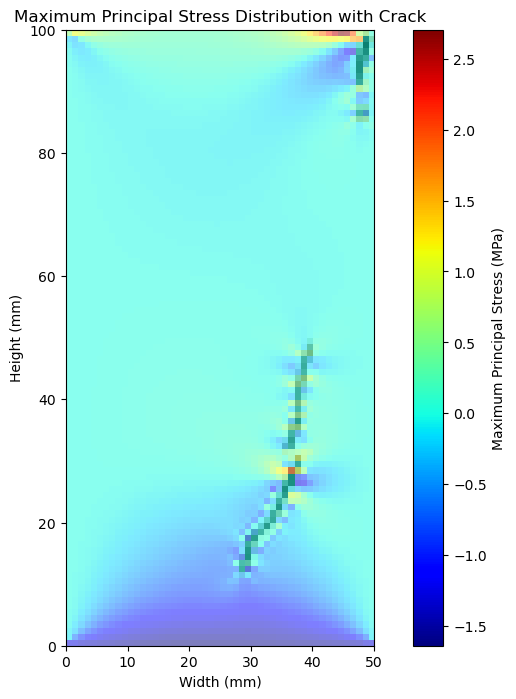

In [9]:
import numpy as np
from scipy.sparse import lil_matrix, csr_matrix
from scipy.sparse.linalg import spsolve
from numba import jit
import matplotlib.pyplot as plt
from PIL import Image

@jit(nopython=True)
def compute_element_matrix(node_coords, E_e, nu, thickness):
    """计算单元刚度矩阵"""
    D = E_e/(1 - nu**2) * np.array([[1, nu, 0],
                                     [nu, 1, 0],
                                     [0, 0, (1-nu)/2]])

    # 高斯积分点
    gauss_points = np.array([(-0.57735026919, -0.57735026919),
                             (0.57735026919, -0.57735026919),
                             (0.57735026919, 0.57735026919),
                             (-0.57735026919, 0.57735026919)])
    weights = np.array([1.0, 1.0, 1.0, 1.0])

    Ke = np.zeros((8, 8))
    for i in range(4):
        xi, eta = gauss_points[i]
        w = weights[i]

        dN_dxi = 0.25 * np.array([
            [eta-1, 1-eta, 1+eta, -eta-1],
            [xi-1, -xi-1, xi+1, 1-xi]
        ])

        J = dN_dxi @ node_coords
        detJ = J[0,0]*J[1,1] - J[0,1]*J[1,0]

        # 计算J的逆矩阵
        invJ = np.array([[J[1,1], -J[0,1]], [-J[1,0], J[0,0]]]) / detJ
        dN_dx = invJ @ dN_dxi

        B = np.zeros((3, 8))
        for j in range(4):
            B[0, 2*j] = dN_dx[0, j]
            B[1, 2*j+1] = dN_dx[1, j]
            B[2, 2*j] = dN_dx[1, j]
            B[2, 2*j+1] = dN_dx[0, j]

        Ke += (B.T @ D @ B) * detJ * w * thickness

    return Ke

def main():
    # 参数设置
    nx, ny = 50, 100
    width, height = 50.0, 100.0
    E = 210e3
    nu = 0.3
    thickness = 1.0
    applied_stress = -6.0

    # 读取mask图像
    mask_image = Image.open("mask.png").convert("L")  # 转为灰度图
    mask_array = np.array(mask_image)
    # 调整mask数组大小以匹配有限元网格
    mask_array = np.array(Image.fromarray(mask_array).resize((nx, ny)))

    # 生成网格
    x = np.linspace(0, width, nx + 1)
    y = np.linspace(0, height, ny + 1)
    X, Y = np.meshgrid(x, y)
    nodes = np.column_stack((X.flatten(), Y.flatten()))

    # 生成单元连接性（向量化操作）
    i = np.arange(nx*ny)
    row = i // nx
    col = i % nx
    n0 = row*(nx+1) + col
    elements = np.column_stack((n0, n0+1, n0+nx+2, n0+nx+1))

    # 使用mask标记裂纹区域（向量化操作）
    E_values = np.where(mask_array.flatten() > 128, 1e-6, E)  # 白色区域弹性模量设为极小值


    # 组装刚度矩阵
    dof = 2 * len(nodes)
    K = lil_matrix((dof, dof))

    # 并行计算单元刚度矩阵
    for elem_idx, elem in enumerate(elements):
        node_coords = nodes[elem]
        Ke = compute_element_matrix(node_coords, E_values[elem_idx], nu, thickness)

        # 组装到全局矩阵
        dofs = np.array([[2*n, 2*n+1] for n in elem]).flatten()
        for i in range(8):
            for j in range(8):
                K[dofs[i], dofs[j]] += Ke[i,j]


    # 边界条件（向量化操作）
    bottom_nodes = np.where(nodes[:,1] == 0.0)[0]
    fixed_dofs = np.concatenate([2*bottom_nodes, 2*bottom_nodes+1])

    # 载荷向量
    F = np.zeros(dof)
    top_nodes = np.where(nodes[:,1] == height)[0]
    force_per_node = applied_stress * width * thickness / len(top_nodes)
    F[2*top_nodes + 1] = force_per_node

    # 处理边界条件
    for fd in fixed_dofs:
        F[fd] = 0.0
        K[fd, :] = 0
        K[:, fd] = 0
        K[fd, fd] = 1.0

    # 转换为CSR格式并求解
    K = csr_matrix(K)
    U = spsolve(K, F)

    # 计算应力（向量化操作）
    stress_matrix = np.zeros((ny, nx))
    for idx, elem in enumerate(elements):
        node_coords = nodes[elem]
        u = np.concatenate([U[2*elem[i]:2*elem[i]+2] for i in range(4)])

        # 计算中心点应力
        xi, eta = 0.0, 0.0
        dN_dxi = 0.25 * np.array([
            [eta-1, 1-eta, 1+eta, -eta-1],
            [xi-1, -xi-1, xi+1, 1-xi]
        ])
        J = dN_dxi @ node_coords
        dN_dx = np.linalg.inv(J) @ dN_dxi

        B = np.zeros((3, 8))
        for i in range(4):
            B[0, 2*i] = dN_dx[0, i]
            B[1, 2*i+1] = dN_dx[1, i]
            B[2, 2*i] = dN_dx[1, i]
            B[2, 2*i+1] = dN_dx[0, i]

        strain = B @ u
        E_e = E_values[idx]
        D = E_e/(1 - nu**2) * np.array([[1, nu, 0],
                                         [nu, 1, 0],
                                         [0, 0, (1-nu)/2]])
        stress = D @ strain

        s_x, s_y, t_xy = stress
        avg = (s_x + s_y)/2
        radius = np.sqrt(((s_x - s_y)/2)**2 + t_xy**2)
        sigma1 = avg + radius
        stress_matrix[idx//nx, idx%nx] = sigma1

    # 绘图
    fig, ax = plt.subplots(figsize=(10, 8))

    # 绘制应力云图
    im = ax.imshow(stress_matrix, cmap='jet', extent=[0, width, 0, height], origin='lower')
    fig.colorbar(im, ax=ax, label='Maximum Principal Stress (MPa)')

    # 绘制裂纹（将mask叠加到应力云图上）
    # 将mask_array的值反转（0变成1，1变成0），然后设置透明度
    mask_display = 1 - (mask_array / 255.0)  # 归一化并反转
    ax.imshow(mask_display, cmap='gray', extent=[0, width, 0, height], origin='lower', alpha=0.5) #alpha值可以调整


    ax.set_xlabel('Width (mm)')
    ax.set_ylabel('Height (mm)')
    ax.set_title('Maximum Principal Stress Distribution with Crack')
    plt.show()

if __name__ == "__main__":
    main()

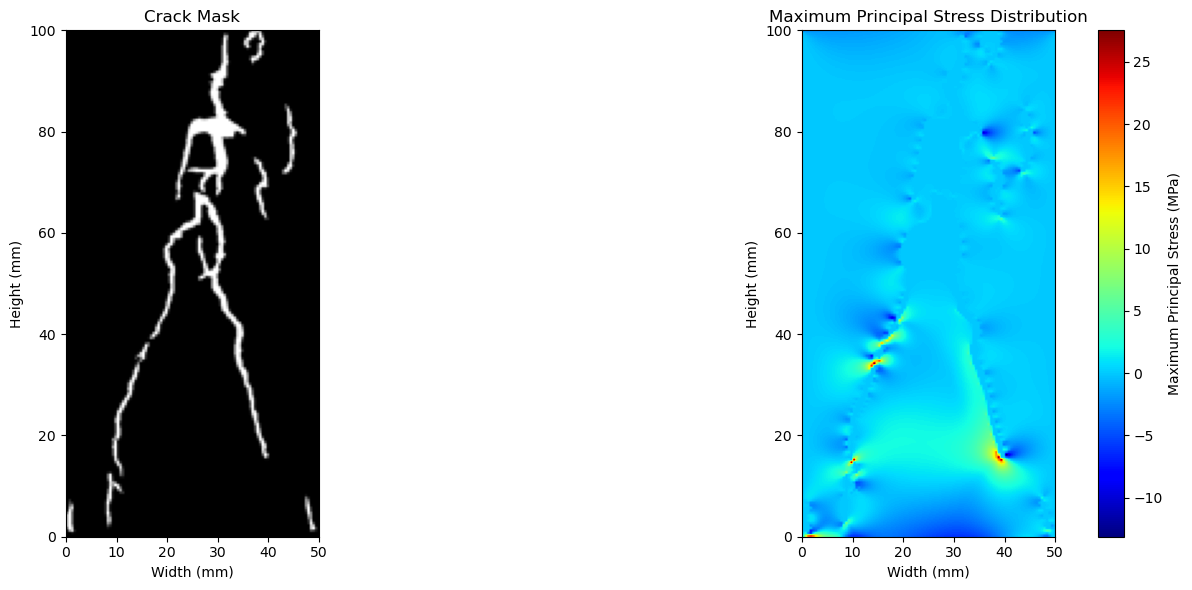

In [16]:
import numpy as np
from scipy.sparse import lil_matrix, csr_matrix
from scipy.sparse.linalg import spsolve
from numba import jit
import matplotlib.pyplot as plt
from PIL import Image

@jit(nopython=True)
def compute_element_matrix(node_coords, E_e, nu, thickness):
    """计算单元刚度矩阵"""
    D = E_e/(1 - nu**2) * np.array([[1, nu, 0],
                                     [nu, 1, 0],
                                     [0, 0, (1-nu)/2]])

    # 高斯积分点
    gauss_points = np.array([(-0.57735026919, -0.57735026919),
                             (0.57735026919, -0.57735026919),
                             (0.57735026919, 0.57735026919),
                             (-0.57735026919, 0.57735026919)])
    weights = np.array([1.0, 1.0, 1.0, 1.0])

    Ke = np.zeros((8, 8))
    for i in range(4):
        xi, eta = gauss_points[i]
        w = weights[i]

        dN_dxi = 0.25 * np.array([
            [eta-1, 1-eta, 1+eta, -eta-1],
            [xi-1, -xi-1, xi+1, 1-xi]
        ])

        J = dN_dxi @ node_coords
        detJ = J[0,0]*J[1,1] - J[0,1]*J[1,0]

        # 计算J的逆矩阵
        invJ = np.array([[J[1,1], -J[0,1]], [-J[1,0], J[0,0]]]) / detJ
        dN_dx = invJ @ dN_dxi

        B = np.zeros((3, 8))
        for j in range(4):
            B[0, 2*j] = dN_dx[0, j]
            B[1, 2*j+1] = dN_dx[1, j]
            B[2, 2*j] = dN_dx[1, j]
            B[2, 2*j+1] = dN_dx[0, j]

        Ke += (B.T @ D @ B) * detJ * w * thickness

    return Ke

def main():
    # 参数设置
    nx, ny = 100, 200
    width, height = 50.0, 100.0
    E = 210e3
    nu = 0.3
    thickness = 1.0
    applied_stress = -6.0

    # 读取mask图像
    mask_image = Image.open("label142.png").convert("L")  # 转为灰度图
    mask_array = np.array(mask_image)
    # 调整mask数组大小以匹配有限元网格
    mask_array = np.array(Image.fromarray(mask_array).resize((nx, ny)))
    
    # 生成网格
    x = np.linspace(0, width, nx + 1)
    y = np.linspace(0, height, ny + 1)
    X, Y = np.meshgrid(x, y)
    nodes = np.column_stack((X.flatten(), Y.flatten()))

    # 生成单元连接性（向量化操作）
    i = np.arange(nx*ny)
    row = i // nx
    col = i % nx
    n0 = row*(nx+1) + col
    elements = np.column_stack((n0, n0+1, n0+nx+2, n0+nx+1))

    # 使用mask标记裂纹区域（向量化操作）
    E_values = np.where(mask_array.flatten() > 128, 1e-6, E)  # 白色区域弹性模量设为极小值


    # 组装刚度矩阵
    dof = 2 * len(nodes)
    K = lil_matrix((dof, dof))

    # 并行计算单元刚度矩阵
    for elem_idx, elem in enumerate(elements):
        node_coords = nodes[elem]
        Ke = compute_element_matrix(node_coords, E_values[elem_idx], nu, thickness)

        # 组装到全局矩阵
        dofs = np.array([[2*n, 2*n+1] for n in elem]).flatten()
        for i in range(8):
            for j in range(8):
                K[dofs[i], dofs[j]] += Ke[i,j]


    # 边界条件（向量化操作）
    bottom_nodes = np.where(nodes[:,1] == 0.0)[0]
    fixed_dofs = np.concatenate([2*bottom_nodes, 2*bottom_nodes+1])

    # 载荷向量
    F = np.zeros(dof)
    top_nodes = np.where(nodes[:,1] == height)[0]
    force_per_node = applied_stress * width * thickness / len(top_nodes)
    F[2*top_nodes + 1] = force_per_node

    # 处理边界条件
    for fd in fixed_dofs:
        F[fd] = 0.0
        K[fd, :] = 0
        K[:, fd] = 0
        K[fd, fd] = 1.0

    # 转换为CSR格式并求解
    K = csr_matrix(K)
    U = spsolve(K, F)

    # 计算应力（向量化操作）
    stress_matrix = np.zeros((ny, nx))
    for idx, elem in enumerate(elements):
        node_coords = nodes[elem]
        u = np.concatenate([U[2*elem[i]:2*elem[i]+2] for i in range(4)])

        # 计算中心点应力
        xi, eta = 0.0, 0.0
        dN_dxi = 0.25 * np.array([
            [eta-1, 1-eta, 1+eta, -eta-1],
            [xi-1, -xi-1, xi+1, 1-xi]
        ])
        J = dN_dxi @ node_coords
        dN_dx = np.linalg.inv(J) @ dN_dxi

        B = np.zeros((3, 8))
        for i in range(4):
            B[0, 2*i] = dN_dx[0, i]
            B[1, 2*i+1] = dN_dx[1, i]
            B[2, 2*i] = dN_dx[1, i]
            B[2, 2*i+1] = dN_dx[0, i]

        strain = B @ u
        E_e = E_values[idx]
        D = E_e/(1 - nu**2) * np.array([[1, nu, 0],
                                         [nu, 1, 0],
                                         [0, 0, (1-nu)/2]])
        stress = D @ strain

        s_x, s_y, t_xy = stress
        avg = (s_x + s_y)/2
        radius = np.sqrt(((s_x - s_y)/2)**2 + t_xy**2)
        sigma1 = avg + radius
        stress_matrix[idx//nx, idx%nx] = sigma1

    # 绘图
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))  # 1行，2列的子图

    # 第一个子图：Mask图像
    axes[0].imshow(mask_array, cmap='gray', extent=[0, width, 0, height])
    axes[0].set_title('Crack Mask')
    axes[0].set_xlabel('Width (mm)')
    axes[0].set_ylabel('Height (mm)')

    # 第二个子图：应力分布
    im = axes[1].imshow(stress_matrix, cmap='jet', extent=[0, width, 0, height])
    axes[1].set_title('Maximum Principal Stress Distribution')
    axes[1].set_xlabel('Width (mm)')
    axes[1].set_ylabel('Height (mm)')
    fig.colorbar(im, ax=axes[1], label='Maximum Principal Stress (MPa)')


    plt.tight_layout()  # 自动调整子图间距
    plt.show()

if __name__ == "__main__":
    main()